# REINFORCE

In this notebook, I will implement REINFORCE algorithm for Cart Pole Environment.

**Mountain Car MDP**


The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## Reinforce

REINFORCE is an elegant algorithm for maximizing the expected return. We sample a trajectory $\tau$ . If we get a high reward, we try to make it more likely. If we get a low reward, we try to make it less likely.

We just need a policy that maximizes the expected return and we can do this by Gradient Ascent on Policy parameters.

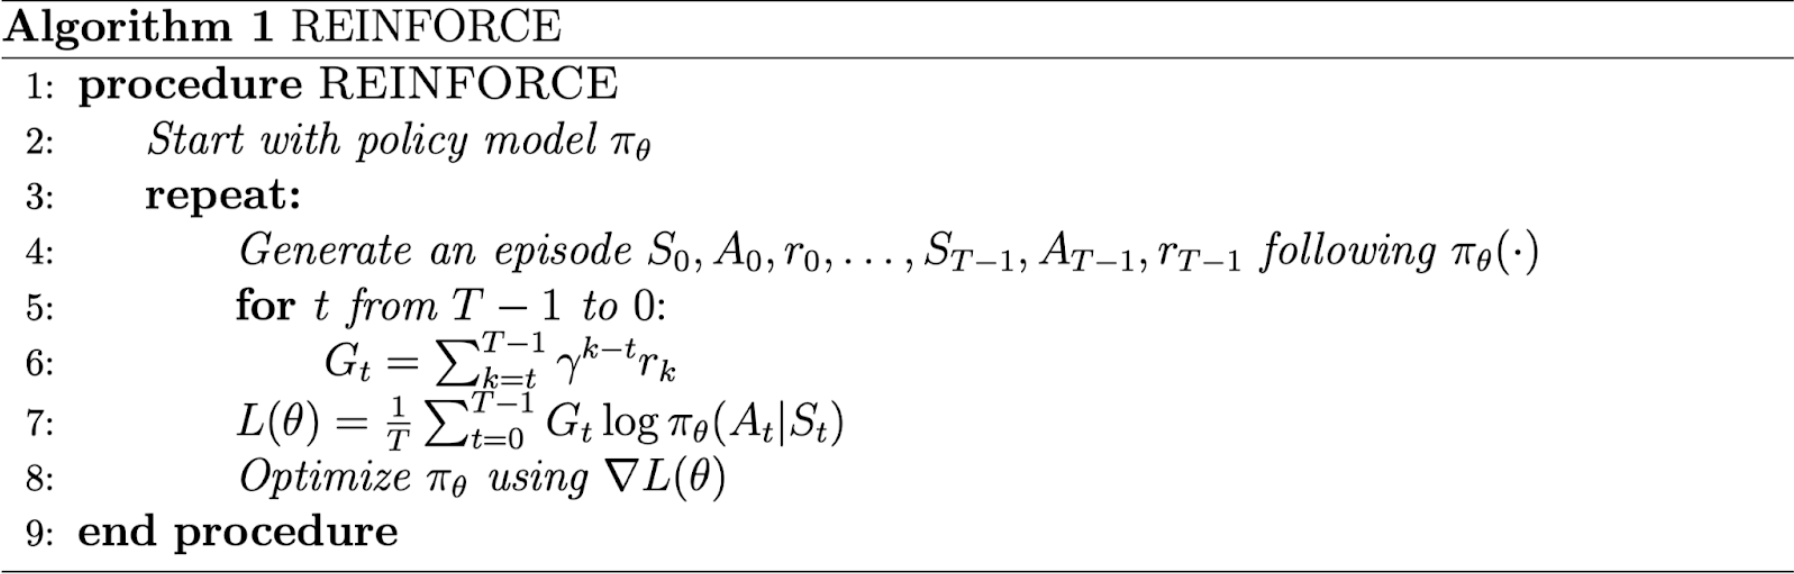




# Reinforce Algorithm

1.   Different NN architecture (Layers, sizes, and more).
2.   Reward function kept as is.
3.   Hyperparameters finetuned as recommended by Mr. |Mubashar and literature.



In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the environment
env = gym.make('MountainCarContinuous-v0', new_step_api=True)


In [ ]:
# A neural network for policy
# It takes the state as input and predicts the probability of each action
class Policy(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Policy, self).__init__()
        self.layer1     =  nn.Linear(n_observations, 128)
        self.dropout1   =  nn.Dropout(p=0.6)

        self.layer2     =  nn.Linear(128           , 256)
        self.dropout2   =  nn.Dropout(p=0.6)

        self.layer3     =  nn.Linear(256           , 128)
        self.dropout3   =  nn.Dropout(p=0.6)

        self.mu_layer   =  nn.Linear(128           , n_actions)
        self.std_layer  =  nn.Linear(128           , n_actions)

    def forward(self, x):
        x   = F.leaky_relu(self.dropout1((self.layer1(x))), negative_slope=2.0)
        x   = F.leaky_relu(self.dropout2((self.layer2(x))), negative_slope=2.5)
        x   = F.leaky_relu(self.dropout3((self.layer3(x))), negative_slope=3.0)

        mu  = self.mu_layer(x)
        std = F.softplus(self.std_layer(x))                                       # std must be positive, use softplus to ensure this
        # Lead to the model to not explore if the agent keeps predicting negative values
        # have the model predict log std instead

        return mu, std


    def act(self, state):
        state   = torch.from_numpy(state).float().to(device)
        mu, std = self.forward(state)
        mu      = mu.cpu()
        std     = std.cpu()
        m       = Normal(mu, std)
        action  = m.sample()
        action  = torch.tanh(action)                                              # apply tanh to the action space
        return action.numpy(), m.log_prob(action)                                 # return action as numpy array


In [ ]:
# Here, we will specify the hyperparameters

total_episodes  = 200                                                             # Total training episodes
max_steps       = 2000000                                                         # Max steps per episode
learning_rate   = 2.5e-3                                                          # Learning rate|
gamma           = 0.999                                                           # Discounting rate

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1


In [ ]:
# Intialize policy network
policy_net = Policy(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [ ]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob = policy_net.act(state)
    # save the log probability for later use
    saved_log_probs.append(log_prob)
    state, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)

    if terminated or truncated:
        break

  scores.append(sum(rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )

  # list[t] = r(t) + gamma* r(t+1) + gamma**2 r(t+2)------gamma**(T-t-1)*r(T)

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  # Calculating policy loss:
  policy_loss = []
  for log_prob, disc_return in zip(saved_log_probs, returns):
    # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
    # remember we want gradient accent of \grad_theta log_prob * A
    # this will become gradient decdone on \grad_theta -log_prob * A
    policy_loss.append(-log_prob * disc_return)
  policy_loss = torch.cat(policy_loss).sum()

  # Back propagation
  optimizer.zero_grad()
  policy_loss.backward()
  optimizer.step()

  print(f"Episode {episode}: Reward = {scores[-1]} Done: {terminated}")


Episode 1: Reward = -72.14126574193862 Done: False
Episode 2: Reward = -81.4680490982577 Done: False
Episode 3: Reward = 51.56851385532009 Done: True
Episode 4: Reward = 24.29294312375862 Done: True
Episode 5: Reward = 44.99162135703363 Done: True
Episode 6: Reward = -88.95805912005176 Done: False
Episode 7: Reward = -88.55941829147287 Done: False
Episode 8: Reward = -90.15925316214626 Done: False
Episode 9: Reward = 50.754191507543254 Done: True
Episode 10: Reward = -90.76625089301696 Done: False
Episode 11: Reward = -90.16111688426021 Done: False
Episode 12: Reward = -90.18560218435722 Done: False
Episode 13: Reward = -90.38725675402722 Done: False
Episode 14: Reward = -89.90684122787147 Done: False
Episode 15: Reward = 18.985668133965092 Done: True
Episode 16: Reward = -92.40591381009723 Done: False
Episode 17: Reward = -92.78419887142628 Done: False
Episode 18: Reward = -93.51447306367552 Done: False
Episode 19: Reward = -92.14526572386102 Done: False
Episode 20: Reward = -92.13420

Text(0, 0.5, 'Reward')

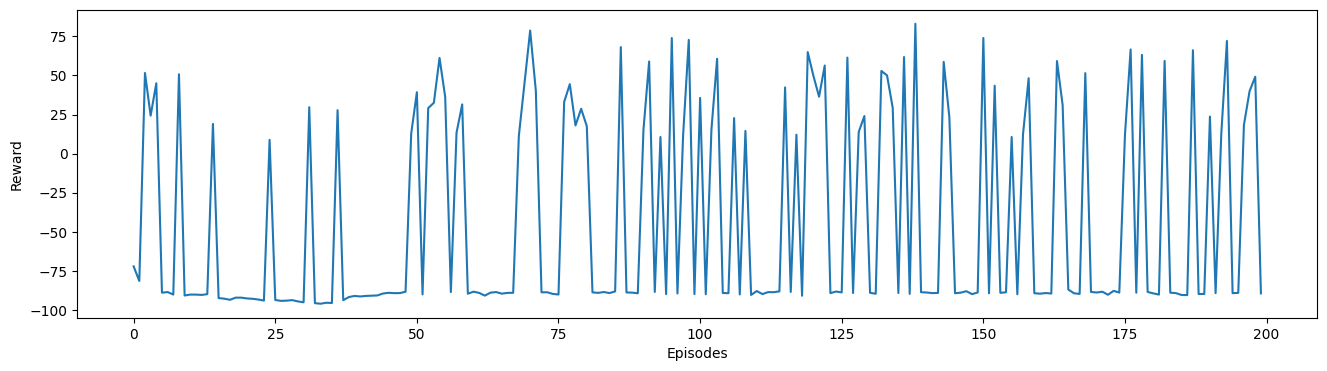

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    for t in range(max_steps):
        vid.capture_frame()
        action, _ = policy_net.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if terminated or truncated:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("MountainCarContinuous-v0")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
show_video("MountainCarContinuous-v0")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Actor Critic

In [ ]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers (we used 2 layers)
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)

    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size * h_size) + h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))

    def get_weights_dim(self):
        return (self.s_size + 1) * self.h_size + (self.h_size + 1) * self.a_size

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x.cpu().data

    def act(self, state):
        state = torch.from_numpy(state).float().to(device)
        with torch.no_grad():
            action = self.forward(state)
        return action

    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return

agent = Agent(env).to(device)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
  - low: [-1.]
  - high: [1.]


Episode 10	Average Score: -1.20
Episode 20	Average Score: -2.08
Episode 30	Average Score: -1.81
Episode 40	Average Score: -1.69
Episode 50	Average Score: -1.50
Episode 60	Average Score: -1.46
Episode 70	Average Score: -1.30
Episode 80	Average Score: -1.24
Episode 90	Average Score: -1.13
Episode 100	Average Score: -1.05
Episode 110	Average Score: -0.95
Episode 120	Average Score: -0.70
Episode 130	Average Score: -0.61
Episode 140	Average Score: -0.53
Episode 150	Average Score: -0.48
Episode 160	Average Score: -0.39
Episode 170	Average Score: -0.36
Episode 180	Average Score: -0.32
Episode 190	Average Score: -0.32
Episode 200	Average Score: -0.32
Episode 210	Average Score: -0.31
Episode 220	Average Score: -0.61
Episode 230	Average Score: 5.23
Episode 240	Average Score: 14.61
Episode 250	Average Score: 24.13
Episode 260	Average Score: 33.45
Episode 270	Average Score: 42.87
Episode 280	Average Score: 52.36
Episode 290	Average Score: 61.70
Episode 300	Average Score: 71.09
Episode 310	Average 

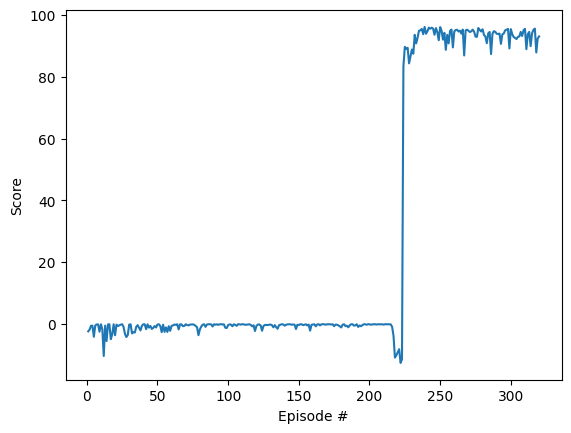

In [ ]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.

    Params:
    ======
        n_iterations (int):                                                       maximum number of training iterations
        max_t (int):                                                              maximum number of timesteps per episode
        gamma (float):                                                            discount rate
        print_every (int):                                                        frequency of printing average score (over last 100 episodes)
        pop_size (int):                                                           size of population at each iteration
        elite_frac (float):                                                       percentage of top performers to use in update
        sigma (float):                                                            standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)

        torch.save(agent.state_dict(), 'checkpoint.pth')

        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        vid.capture_frame()

        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break
    env.close()

In [ ]:
agent = Agent(env).to(device)
show_video_of_model(agent, 'MountainCarContinuous-v0')

In [ ]:
show_video('MountainCarContinuous-v0')